Reference: https://github.com/openai/gym/wiki/MountainCar-v0

Video: https://www.youtube.com/watch?v=7sgilwJ9Fig

In [1]:
if(False):
    !pip install gym #environments
    !pip install keras #neural networks

In [1]:
import gym
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

from collections import deque


import RigidBody as rb
import Simulator as sm
import outputParse
import ActionSpace as a_s

from scipy.integrate import odeint
from pyquaternion import Quaternion

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import time


Using TensorFlow backend.


In [3]:
#create simulation

tick_length = 1./30.  #step length between physics checks, don't change this
seconds = 50.     #seconds to simulate
step_size = 1.        # intervals to print seconds at. -1 for no print
verbose = False     #true to print

action_size = 8
state_size = 13 + action_size #don't change this, default = 13, agentActions = 8
sim = sm.Simulation(state_size, action_size) #create simulator

mass = 10. #mass of the object
dim = np.array([1.,1.,1.]) #dimensions of the cube object
x = np.array([0.,0.,1.]) #position
q = Quaternion(np.array([0.,0.,0.,1.])) #rotation
p = np.array([0.,0.,0.]) #linear momentum
l = np.array([0.,0.,0.]) #angular momentum
objectType = "Agent"
objectName = "Prime"
    #forward, back, up, down, left, right, rollleft, rollright
thrusts = np.array([50.,0.5 ,0.5,0.5 ,0.5,0.5, 0.5,0.5]) #the thrust magnitude for the various thrusters
loadtime = 10. #ten second load time between firing projectiles
sim.createObject(mass, dim, x, q, p, l, objectType, objectName, thrusts, loadtime) #add cube object to bodies

trackTotalOutput = False #enable if you want visualization
state = sim.createSimulation(tick_length, trackTotalOutput)

In [5]:
# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, env):
        self.env = env # environment
        self.state_size = env.state_size # number of state parameters
        self.action_size = env.action_space.rows # number of possible actions
        self.memory = deque(maxlen=10000) # memory stores max of 10000 events
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01 
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001 # for the neural net
        self.model = self._build_model() # untrained neural net
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        # Store this experience in memory
        pos = next_state[0][0]
        v = next_state[0][1]
        
        # Changing the reward function!
        #reward = abs(v) + abs(pos + 0.5)/10
        #reward = reward + 1
        
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        # Act in an epsilon greedy manner
        if np.random.rand() <= self.epsilon:
            return env.action_space.sample()
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  
    
    def act_greedy(self, state):
        # Act in a greedy manner after environment is solved
        return np.argmax(self.model.predict(state)[0]) 
    
    def replay(self, batch_size):
        # Learn from past experiences
        if batch_size > len(self.memory):
            print("batch size greater than memory length")
            return
        print("one")
        minibatch = random.sample(self.memory, batch_size) # Pick a random x amount of experiences to learn from
        for state, action, reward, next_state, done in minibatch:
            print("minibatch")
            target = reward 
            # If we're at a terminal state, no need to look at next state
            if not done:
                # Standard value function
                print("a0")
                temp1 = self.model.predict(next_state)
                print("a1")
                print(temp1)
                target = reward + self.gamma * temp1[0]
            print("minibatch1")
            target_f = self.model.predict(state)
            print("minibatch2")
            target_f[0][action] = target # alpha = 1 in this agent
            print("minibatch3")
            self.model.fit(state, target_f, epochs=1, verbose=0)
            print("minibatch_done")
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        print("replayed")
            
          

In [ ]:
# initialize gym environment and the agent
env = sim
agent = DQNAgent(env)
episodes = 5000
rewards = deque(maxlen=100)

#Build Memory
print("Building Memory")
for i in range(51):
    state = env.reset()
    state = np.reshape(state, [1, 21])
    done = False
    while not done:
        action = np.array([agent.act(state)])
        next_state, reward, done = env.runSimulation(action)
        next_state = np.reshape(next_state, [1, 21])
        agent.remember(state, action, reward, next_state, done)
        state = next_state


#Learn
print("Learning")
for e in range(episodes):
    print(e)
    state = env.reset()
    state = np.reshape(next_state, [1, 21])
    done = False
    R = 0
    while not done:
        action = np.array([agent.act(state)])
        next_state, reward, done = env.runSimulation(action)
        next_state = np.reshape(next_state, [1, 21])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        R += reward
        if done:
            print("episode: {}/{}, reward: {}, average: {}"
                  .format(e+1, episodes, R, np.average(rewards)))
            rewards.append(R)
            break
    if e >= 3 and np.average(rewards) >= 300:
        print("Environment Solved")
        break
    print("replaying...")
    agent.replay(50)

Building Memory
Learning
0
episode: 1/5000, reward: -15049.680813967445, average: nan
replaying...
one
minibatch
a0


In [0]:
!pip -q install pyopengl
!pip -q install pyvirtualdisplay
!pip -q install pyglet
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'


test episode: 0 R: 200.0
test episode: 1 R: 200.0
test episode: 2 R: 200.0


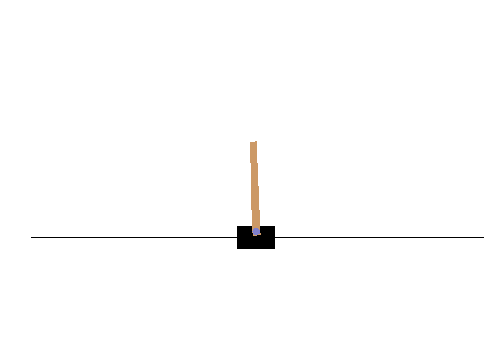

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

frames = []
for i in range(3):
    obs = env.reset()
    obs = obs.reshape(1,4)
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act_greedy(obs)
        obs, r, done, _ = env.step(action)
        obs = obs.reshape(1,4)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

In [5]:

if(True):
    env = gym.make('MountainCar-v0')
    print(env.observation_space)
    print(env.observation_space.high)
    print(env.observation_space.low)
    print("\n")
    print(env.action_space)
    print(env.action_space.n)
    print("\n\n")
    obs = env.reset()
    sample = env.action_space.sample()
    print(sample)
    next = env.step(sample)
    print(next)
    sample = env.action_space.sample()
    print(sample)
    next = env.step(sample)
    print(next)
    sample = env.action_space.sample()
    print(sample)
    next = env.step(sample)
    print(next)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Box(2,)
[0.6  0.07]
[-1.2  -0.07]


Discrete(3)
3



0
(array([-0.44997301, -0.00155912]), -1.0, False, {})
2
(array([-0.45107984, -0.00110683]), -1.0, False, {})
0
(array([-0.45372629, -0.00264644]), -1.0, False, {})


/Users/jbunker/miniconda3/envs/CMSC422/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
